# Advection-Diffusion: Discontinuous Galerkin Method with Upwinding
So far we have been using Lagrange spaces of different order to solve our
PDE. In the following we show how to use Discontinuous Galerkin method to
solve an advection dominated advection-diffusion probllem:
\begin{align*}
-\varepsilon\triangle u + b\cdot\nabla u &= f
\end{align*}
with Dirichlet boundary conditions. Here $\varepsilon$ is a small
constant and $b$ a given vector.

In [1]:
import numpy, math
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
from dune.grid import structuredGrid as leafGridView
from dune.fem.space import dglegendre as dgSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.ufl import Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate, triangle, FacetNormal
from ufl import dx, ds, grad, div, grad, dot, inner, sqrt, exp, conditional
from ufl import as_vector, avg, jump, dS, CellVolume, FacetArea, atan

gridView = leafGridView([-1, -1], [1, 1], [20, 20])
space    = dgSpace(gridView, order=2)

u    = TrialFunction(space)
v    = TestFunction(space)
n    = FacetNormal(space)
he   = avg( CellVolume(space) ) / FacetArea(space)
hbnd = CellVolume(space) / FacetArea(space)
x    = SpatialCoordinate(space)

# diffusion factor
eps = Constant(0.1,"eps")
# transport direction and upwind flux
b    = as_vector([1,0])
hatb = (dot(b, n) + abs(dot(b, n)))/2.0
# boundary values (for left/right boundary)
dD   = conditional((1+x[0])*(1-x[0])<1e-10,1,0)
g    = conditional(x[0]<0,atan(10*x[1]),0)
# penalty parameter
beta = 10*space.order**2

aInternal     = dot(eps*grad(u) - b*u, grad(v)) * dx
diffSkeleton  = eps*beta/he*jump(u)*jump(v)*dS -\
                eps*dot(avg(grad(u)),n('+'))*jump(v)*dS -\
                eps*jump(u)*dot(avg(grad(v)),n('+'))*dS
diffSkeleton += eps*beta/hbnd*(u-g)*v*dD*ds -\
                eps*dot(grad(u),n)*v*dD*ds
advSkeleton   = jump(hatb*u)*jump(v)*dS
advSkeleton  += ( hatb*u + (dot(b,n)-hatb)*g )*v*dD*ds
form          = aInternal + diffSkeleton + advSkeleton

scheme = solutionScheme(form==0, solver="gmres",
            parameters={"newton.linear.preconditioning.method":"jacobi"})

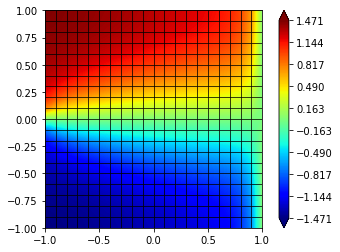

In [2]:
uh = space.interpolate(0, name="solution")
info = scheme.solve(target=uh)
uh.plot()

So far the example was not really advection dominated so we now
repeat the experiment but set $\varepsilon=1e-5$

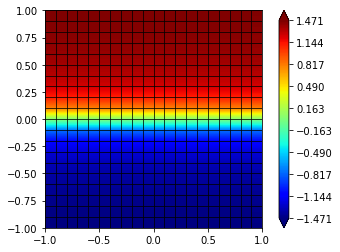

In [3]:
eps.value = 1e-5 # could also use scheme.model.eps = 1e-5
uh.interpolate(0)
scheme.solve(target=uh)
uh.plot()